# Direct comparison of PIP for susie, DAP and CAVIAR

DAP and CAVIAR is performed on some of the same input data and is compared with `susie`.

In [1]:
%revisions -s

Revision,Author,Date,Message
00da2df,Gao Wang,2018-06-05,Add more PIP comparisons
d1835be,Gao Wang,2018-05-31,Fix CAVIAR vs susie outlier comparison
7b277dc,Gao Wang,2018-05-31,Explore CAVIAR vs susie PIP for n = 1
4324e0d,Gao Wang,2018-05-31,Add data-set names that created DAP issues
a0a3c0b,Gao Wang,2018-05-31,Fix up PIP plot
d544c5d,Gao Wang,2018-05-31,Add caviar comparison plots
185fff8,Gao Wang,2018-05-29,Add ROC and PIP evaluations
61fd3cb,Gao Wang,2018-05-29,Plot computed PIP before / after LD filtering
ecc5b49,Gao Wang,2018-05-29,Update documentation
183fea4,Gao Wang,2018-05-29,Convert interactive exploration to pipeline


## Plan

Here I consider the following scenarios:

- Fix total PVE to 0.2
- Scenario with growing difficulty: from 1 causal to 5 causal

For CAVIAR I only try and report 1~3 causal scenarios.

The plan is to get the PIP for those in susieR mappable CS (purity > 0.2 or 0.25), and compare these PIP to what DAP and CAVIAR reports. For susie flavors:

- use prior = 0.1 (may not matter)
- use estimate_residule = False (conservative)

This setting of susie should reflect its best performance. Additionally I check both the PIP computed before purity filter, and that after purity filter.

## Expected outcome

- PIP plots, 3-way: susie vs DAP, susie vs CAVIAR, DAP vs CAVIAR
- False discovery at set / cluster level
- A coarse ROC plot: report signals identified vs signal missed -- number of causal, under the same PVE setup.

Previously I've ran this specific DSC using:

```
dsc susie.dsc --target run_comparison -o susie_comparison
```

So here I query from that result.

## Major conclusions

1. Little difference in PIP before / after filtering LD
2. susie with estimated residual variance is a bit anti-conservative but is acceptable. susie with residual variance being `var(Y)` is too conservative.

## Workflow

Run the `pip`, and `fdr` workflow in [this notebook](20180527_PIP_Workflow.html)

## PIP comparisons

### susie `var(Y)` vs DAP

compare PIP before / after LD filter

> /home/gaow/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_dap_estvar_false_filter_true_0.png (59.8 KiB):

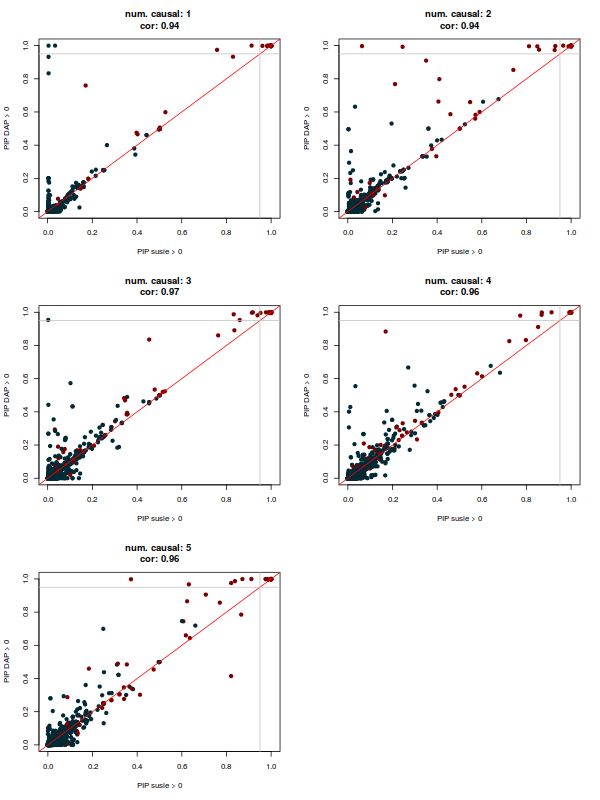

In [2]:
%preview ~/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_dap_estvar_false_filter_true_0.png

> /home/gaow/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_dap_estvar_false_filter_false_0.png (59.6 KiB):

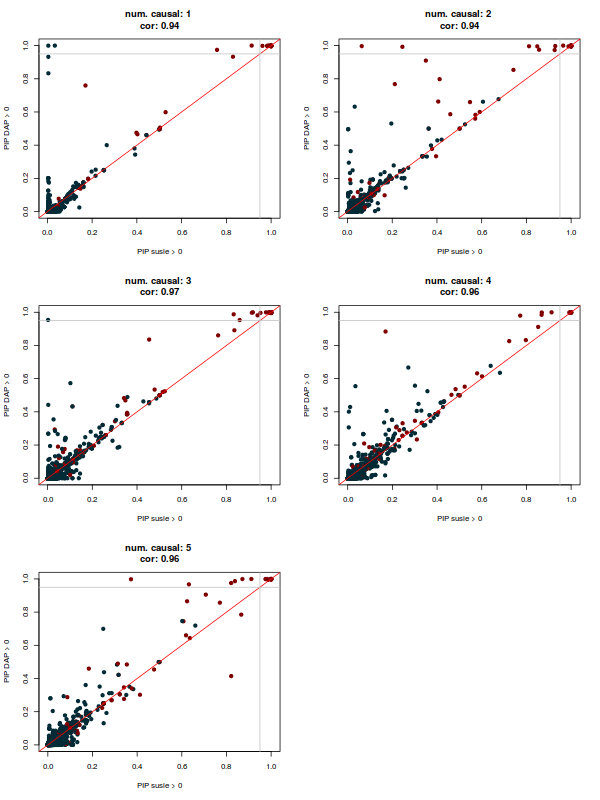

In [4]:
%preview ~/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_dap_estvar_false_filter_false_0.png

No big difference filtering LD before PIP computation.

### susie `est_var` vs DAP

> /home/gaow/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_dap_estvar_true_filter_true_0.png (59.4 KiB):

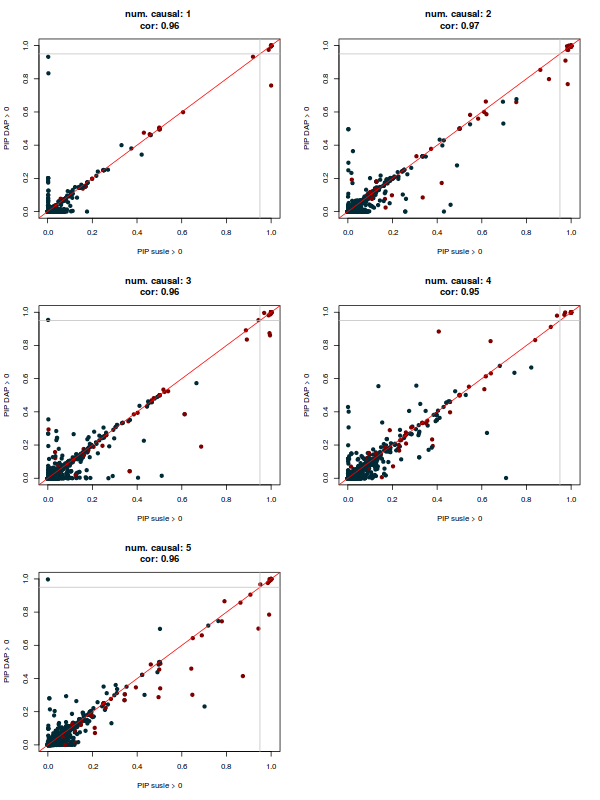

In [5]:
%preview ~/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_dap_estvar_true_filter_true_0.png

It seems results using estimated variance is a bit anti-conservative. But using `var(Y)` is conservative.

### susie `var(Y)` vs CAVIAR

> /home/gaow/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_caviar_estvar_false_filter_true_0.png (51.1 KiB):

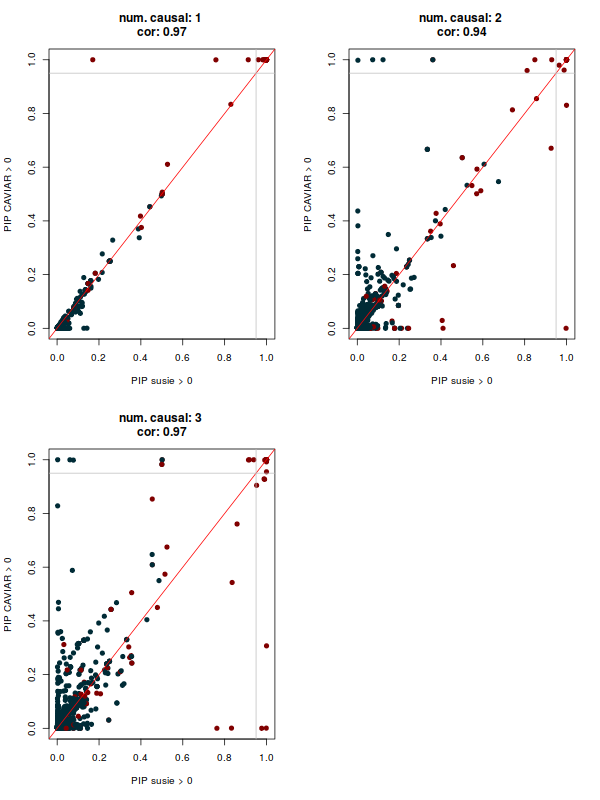

In [6]:
%preview ~/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_caviar_estvar_false_filter_true_0.png

### susie `est_var` vs CAVIAR

> /home/gaow/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_caviar_estvar_true_filter_true_0.png (51.7 KiB):

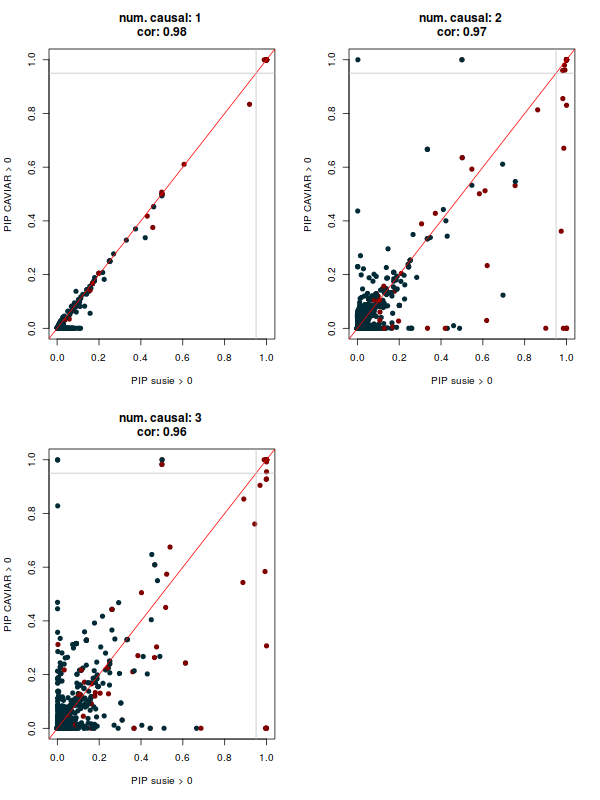

In [7]:
%preview ~/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.susie_caviar_estvar_true_filter_true_0.png

### DAP vs CAVIAR

> /home/gaow/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.dap_caviar_estvar_true_filter_true_0.png (50.4 KiB):

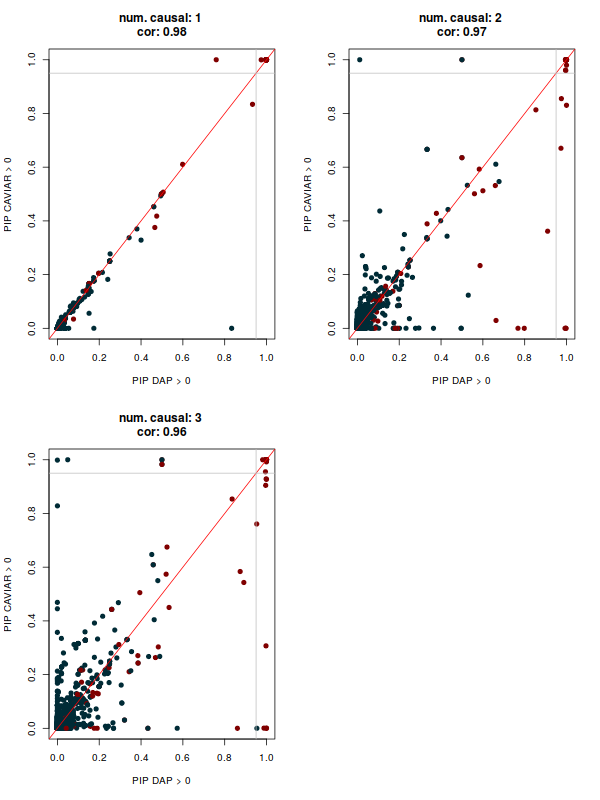

In [9]:
%preview ~/GIT/github/mvarbvs/dsc/susie_comparison/PIP_comparison_0528.dap_caviar_estvar_true_filter_true_0.png

## PIP outlier cases

Here we try to check out what seems interesting about DAP and CAVIAR. We will worry about susie in a separate notebook.

### susie vs DAP 

Under 1-causal signal situation, there are some "outliers" for DAP -- high PIP that are not true signals, and correctly they have low PIP for susie. I document the simulation data-sets that resulted in such results:

```
[1] "~/Documents/GTExV8/Toys/Thyroid.ENSG00000031823.RDS"
[1] "~/Documents/GTExV8/Toys/Thyroid.ENSG00000124102.RDS"
[1] "~/Documents/GTExV8/Toys/Thyroid.ENSG00000135436.RDS"
```

**FIXME: to check these in detail why DAP reports false positives, under these scenarios**

### susie `var(Y)` vs CAVIAR

Under 1-causal signal situation, susie CS indeed captures all the simulated causal variables. So it is indeed some "gold standard". What looks puzzling are the 3 signals having susie PIP < 0.95 but CAVIAR PIP > 0.95. I document these 3 instances in the workflow `pip_2`'s log file.

- For instance 1, CAVIAR PIP reports exactly 1 for that one single variable. The corresponding susie CS has 8 variables, with minimum LD 0.969 (ENSG00000144445)

- For instance 2, CAVIAR PIP is 0.9996 for a single variable. The corresponding susie CS has 6 variables, with minimum LD 0.967 (ENSG00000155324)

- For instance 3, CAVIAR PIP is 1 for a single variable. The corresponding susie CS has 15 variables, with minimum LD 0.993 (ENSG00000156738)

We looked into the results in a [separate notebook](20180601_One_Causal_CAVIAR_Exam.html). It seems due to the large effect size, the residual variance estimated by `var(Y)` is too conservative. Using `estimate_residual_variance=TRUE` we get same results as CAVIAR.

## FDR comparison, susie vs DAP

DAP cluster is filtered by 95% cluster_prob

In [2]:
%cd ~/GIT/github/mvarbvs/dsc

/home/gaow/GIT/github/mvarbvs/dsc

Use `var(Y)` for susie:

In [4]:
readRDS('susie_comparison/FDR_comparison_0528_cluster_prob_estvar_false.rds')

n_signal,expected_discoveries,susie_discoveries,dap_discoveries,susie_power,dap_power,susie_fdp,dap_fdp
1,50,50,56,1.0000000,0.9600000,0.00000000,0.14285714
2,100,71,73,0.6700000,0.6800000,0.05633803,0.06849315
3,150,84,87,0.5466667,0.5466667,0.02380952,0.05747126
4,200,75,74,0.3300000,0.3200000,0.12000000,0.13513514
5,250,74,71,0.2840000,0.2560000,0.04054054,0.09859155


Use estimated residual variance:

In [5]:
readRDS('susie_comparison/FDR_comparison_0528_cluster_prob_estvar_true.rds')

n_signal,expected_discoveries,susie_discoveries,dap_discoveries,susie_power,dap_power,susie_fdp,dap_fdp
1,50,50,56,1.000,0.9600000,0.00000000,0.14285714
2,100,78,73,0.720,0.6800000,0.07692308,0.06849315
3,150,94,87,0.600,0.5466667,0.04255319,0.05747126
4,200,84,74,0.360,0.3200000,0.14285714,0.13513514
5,250,81,71,0.304,0.2560000,0.06172840,0.09859155


Now we check on cases that DAP did not behave well.

### Signals that susie captures but DAP misses, for n = 1 case

A typical case is that the set is large yet highly correlated, eg:

```
susie:
  [1] 335 531 532 533 536 538 539 540 541 542 543 544 546 547 548 549 550 551
 [19] 552 553 554 556 558 559 560 562 563 564 565 566 567 568 569 570 571 574
 [37] 575 576 577 578 579 581 585 586 587 588 591 592 593 594 597 598 601 602
 [55] 603 608 609 610 611 612 613 614 616 617 618 620 621 623 626 628 629 630
 [73] 633 634 635 639 641 642 645 646 647 648 650 651 652 653 654 655 656 657
 [91] 659 660 661 662 663 673 675 676 678 679 681 685 686 687 688 689 690 691
[109] 692 696 698 699 700 701 702 703 704 705 706 707 708 709 710 714 715 719
[127] 720 721 722 723 726 730 732 733 735 736 738 744 745 746

DAP:
list()
  cluster cluster_prob cluster_avg_r2
0       1     0.398200          0.992
1       2     0.006435          0.749
                                                                                                                                                                      snp
0 700,648,646,543,673,581,721,738,560,586,714,701,662,735,618,696,736,621,702,623,587,733,679,732,726,710,708,678,692,691,690,689,688,652,635,639,641,633,629,617,616,620
1                                                                                                                                                             152,361,515
[1] "~/Documents/GTExV8/Toys/Thyroid.ENSG00000083937.RDS"
```
So susie's CS is quite large. For the first cluster DAP comes up with, the avg r2 is high, and overlaps with susie CS, but the `cluster_prob` it computes is low. But indeed that cluster does contain the causal variable.

### DAP false discovery, for n = 1 case

Mostly I see are physically close signals falling in different DAP clusters, eg:

```
susie (and the truth)
[1] 765

DAP
[[1]]
[1] 765

[[2]]
[1] 786

  cluster cluster_prob cluster_avg_r2
0       1    0.9998000          1.000
1       2    0.9995000          1.000
...
[1] "~/Documents/GTExV8/Toys/Thyroid.ENSG00000031823.RDS"
```

and a more extreme case:

```
susie (and the truth)
[1] 669

DAP
[[1]]
[1] 669

[[2]]
 [1] 452 724 717 480 666 665 649 638 632 622 499 524 747 742 734 712 711 693 670
[20] 671 643 584 514 495 504 520 516 517 511 507 501 498 485 486 490 530 453

  cluster cluster_prob cluster_avg_r2
0       1    1.0000000          1.000
1       2    0.9973000          0.984
...
[1] "~/Documents/GTExV8/Toys/Thyroid.ENSG00000083937.RDS"
```

where the 2nd cluster has some variables (eg 665 and 666) very near the first cluster's only variable (669). But they ended up in a different cluster.